In [2]:
#required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import nlp
import tensorflow as tf
from transformers import pipeline, AutoTokenizer

#setting to avoid truncation of the text rows

pd.set_option('display.max_colwidth', None)

In [3]:
data2 = pd.read_csv('c:/Data_Science/IH_Notebooks/IH_NLP_Final_Project/labeled_data.csv')

hate_df = data2.copy()

hate_df = hate_df[['tweet', 'class']]

In [4]:
hate_df = hate_df.rename(columns={'tweet': 'text', 'class': 'label'})

In [5]:
import re

#cleaning the text
def clean_text(text):

    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

hate_df['clean_text'] = hate_df['text'].apply(clean_text)


In [6]:
hate_df = hate_df.drop(columns='text')

In [7]:
hate_label_placeholder = hate_df.pop('label')

hate_df['label'] = hate_label_placeholder

In [8]:
from sklearn.utils import resample

hate_df = hate_df.rename(columns={'clean_text' : 'text'})

hate_speech = hate_df.loc[hate_df['label'] == 0]
offensive_speech = hate_df.loc[hate_df['label'] == 1]
neutral_speech = hate_df.loc[hate_df['label'] == 2]

hate_speech = resample(hate_speech, replace=True, n_samples= 1430, random_state=42)
offensive_speech = resample(offensive_speech, replace=True, n_samples=2570, random_state=42)
neutral_speech = resample(neutral_speech, replace=True, n_samples=2000, random_state=42)

undersampled_hate_dfs = [hate_speech, offensive_speech, neutral_speech]

undersampled_hate_df = pd.concat(undersampled_hate_dfs, ignore_index=True)

print("First 3 rows of hate_df after resampling: \n", undersampled_hate_df.head(3))

First 3 rows of hate_df after resampling: 
                                                                                                                         text  \
0  i hate when faggots talk shit on here then block me so i cant respond bitch i will write you a letter with my response an   
1                                                     jennifer lawrences nudes sooooo trash im still smashin though no doubt   
2                                                     this kid looks like a retard when he tries hiding his phone so obvious   

   label  
0      0  
1      0  
2      0  


In [9]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
#setting the language to English
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def stopword_remove(text):
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

undersampled_hate_df['text'] = undersampled_hate_df['text'].apply(stopword_remove)

# Model compilation with Adam optimizer

In [11]:
from sklearn.model_selection import train_test_split
#RoBERTa base model

X = undersampled_hate_df['text']
y = undersampled_hate_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

#Tokenizer

from transformers import AutoTokenizer, AutoConfig, TFAutoModelForSequenceClassification

model_name = "j-hartmann/emotion-english-distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, num_labels=3)

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some weights of TFRobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier/out_proj/kernel:0: found shape (768, 7) in the checkpoint and (768, 3) in the model instantiated
- classifier/out_proj/bias:0: found shape (7,) in the checkpoint and (3,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def hate(text):
    """
    This function will return the grade expressed in the text
        returns_tensors="tf" will return the tokens as a TensorFlow tensor
        max_length=512 will limit the number of tokens to 512
        truncation=True will truncate the text if it exceeds the max_length
        padding="longest" will pad the text to the longest sequence in the batch
    """
    encoded_text = tokenizer(text, return_tensors="tf", max_length=512, truncation=True, padding="longest")
    output = model(encoded_text)
    scores = output.logits[0].numpy()
    moods = {
        "Hate Speech": scores[0],
        "Offensive Language": scores[1],
        "Neither": scores[2]
    }

    max_mood = max(moods, key=moods.get)
    print(f"Your mood appear to be {max_mood}")

    if max_mood == 'Hate Speech':
        print(f"The detected violence is {max_mood}. Flag to the operating team.")
    elif max_mood == 'Offensive Language':
        print(f"The detected violence is {max_mood}. Flag to the operating team.")
    else:
        print(f"The detected emotion is {max_mood}. No further action needed.")
    return moods

In [13]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors="tf")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors="tf")

import tensorflow as tf

train_labels = tf.convert_to_tensor(list(y_train))
test_labels = tf.convert_to_tensor(list(y_test))

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

In [14]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [15]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [16]:
model.fit(train_dataset, validation_data=test_dataset, epochs=3)

Epoch 1/3


300/300 [==============================] - 2272s 8s/step - loss: 0.5898 - accuracy: 0.7654 - val_loss: 0.4369 - val_accuracy: 0.8325
Epoch 2/3
300/300 [==============================] - 565s 2s/step - loss: 0.4086 - accuracy: 0.8462 - val_loss: 0.3692 - val_accuracy: 0.8642
Epoch 3/3
300/300 [==============================] - 561s 2s/step - loss: 0.3187 - accuracy: 0.8821 - val_loss: 0.3423 - val_accuracy: 0.8767


In [17]:
import numpy as np

preds_hate_logits = model.predict(test_dataset)

75/75 [==============================] - 32s 402ms/step


In [18]:
y_pred = np.argmax(preds_hate_logits.logits, axis=1)

In [19]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
    'sexual violence', 'physical violence', 'EET'
]))

Accuracy: 0.8766666666666667

Detailed Classification Report:
                   precision    recall  f1-score   support

  sexual violence       0.86      0.72      0.79       315
physical violence       0.85      0.90      0.88       502
              EET       0.91      0.97      0.94       383

         accuracy                           0.88      1200
        macro avg       0.88      0.86      0.87      1200
     weighted avg       0.88      0.88      0.87      1200



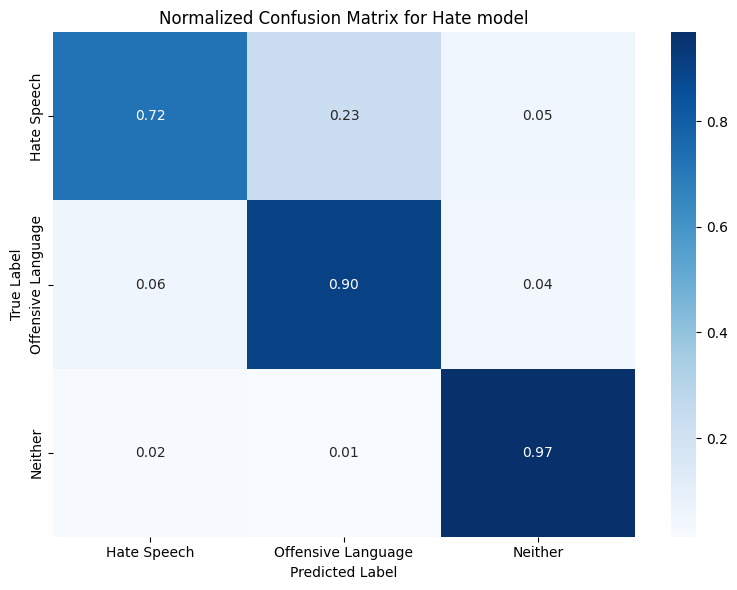

In [20]:
labels = ['Hate Speech', 'Offensive Language', 'Neither']

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix for Hate model')
plt.tight_layout()
plt.show()

In [21]:
model.save("models/hate_roberta_model")

INFO:tensorflow:Assets written to: models/hate_roberta_model\assets


INFO:tensorflow:Assets written to: models/hate_roberta_model\assets


In [22]:
tokenizer.save_pretrained("models/hate_tokenizer")

('models/hate_tokenizer\\tokenizer_config.json',
 'models/hate_tokenizer\\special_tokens_map.json',
 'models/hate_tokenizer\\vocab.json',
 'models/hate_tokenizer\\merges.txt',
 'models/hate_tokenizer\\added_tokens.json',
 'models/hate_tokenizer\\tokenizer.json')

In [23]:
model.save_pretrained("models/models/hate_roberta_model")
tokenizer.save_pretrained("models/models/hate_tokenizer")

('models/models/hate_tokenizer\\tokenizer_config.json',
 'models/models/hate_tokenizer\\special_tokens_map.json',
 'models/models/hate_tokenizer\\vocab.json',
 'models/models/hate_tokenizer\\merges.txt',
 'models/models/hate_tokenizer\\added_tokens.json',
 'models/models/hate_tokenizer\\tokenizer.json')